# Time-Dependent SIR Model

Adapted from https://arxiv.org/abs/2003.00122

Shoutout to the study authors for providing source code

In [1]:
# CD to local directory
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 300)

from datetime import timedelta, datetime
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
sns.set()

from model_helper import *

In [3]:
# Helper functions
def clean_df(df_metric, country='US', metric='Confirmed', start_date = '2020-01-22'):
    dropCols = ['Province/State', 'Country/Region','Lat','Long']
    df = df_metric[df_metric['Country/Region'] == country].drop(dropCols,axis=1).T.reset_index()
    df.columns = ['Date',metric]
    df['Date'] = pd.to_datetime(df.Date).dt.date
    
    df['EpidemicStartDate'] = df.sort_values(by='Date').loc[df[metric]!=0].Date.iloc[0]
    df['DaysElapsed'] = (df.Date - df.EpidemicStartDate).dt.days + 1

    return df[['Date','DaysElapsed',metric]].loc[df.Date >= pd.to_datetime(start_date)]

def data_split(data, orders, start):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]
        
    return x_train, y_train

In [4]:
# Read in data from Johns Hopkins CSSE for US
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths_df    = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

start_date   = '2020-03-01'
X_cml        = np.array(clean_df(confirmed_df, 'US', 'Confirmed', start_date).Confirmed, dtype=np.float64)
recovered    = np.array(clean_df(recovered_df, 'US', 'Recovered', start_date).Recovered, dtype=np.float64)
death        = np.array(clean_df(deaths_df,    'US', 'Deaths',    start_date).Deaths,    dtype=np.float64)

population   = 329500000

In [5]:
# Preprocessing
X = X_cml - recovered - death
R = recovered + death

n = np.array([population] * len(X), dtype=np.float64)

S = n - X - R

gamma = np.diff(R) / X[:-1]
beta = (np.diff(X) + np.diff(R))/X[:-1]
R0 = beta / gamma

print("The latest transmission rate (beta) of SIR model:", beta[-1])
print("The latest recovering rate (gamma) of SIR model:", gamma[-1])
print("The latest basic reproduction number R0:", round(R0[-1],3))

The latest transmission rate (beta) of SIR model: 0.052668572140620866
The latest recovering rate (gamma) of SIR model: 0.012731499509353436
The latest basic reproduction number R0: 4.137


In [6]:
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression as Linear

# Orders of the two FIR filters (How many previous observations to predict from)
orders_beta = 4
orders_gamma = 4

# Starting day for the data training
start_beta = len(beta) - 21
start_gamma = len(beta) - 28

# Create a feature set consisting of previous three Y observations as X1, X2, and X3
x_beta, y_beta = data_split(beta, orders_beta, start_beta)
x_gamma, y_gamma = data_split(gamma, orders_gamma, start_gamma)

# Train and test using KNN regression
# clf_beta  = KNN(n_neighbors=4, weights='uniform').fit(x_beta, y_beta)
# clf_gamma = KNN(n_neighbors=14, weights='uniform').fit(x_gamma, y_gamma)

# Train and test using Ridge regression
clf_beta  = Ridge(alpha=0.003255, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
# clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)

# Train and test using Linear regression
# clf_beta  = Linear(normalize=False, copy_X=True).fit(x_beta, y_beta)
clf_gamma = Linear(normalize=False, copy_X=True).fit(x_gamma, y_gamma)

# Predict rates over last several weeks 
beta_hat = clf_beta.predict(x_beta)
gamma_hat = clf_gamma.predict(x_gamma)

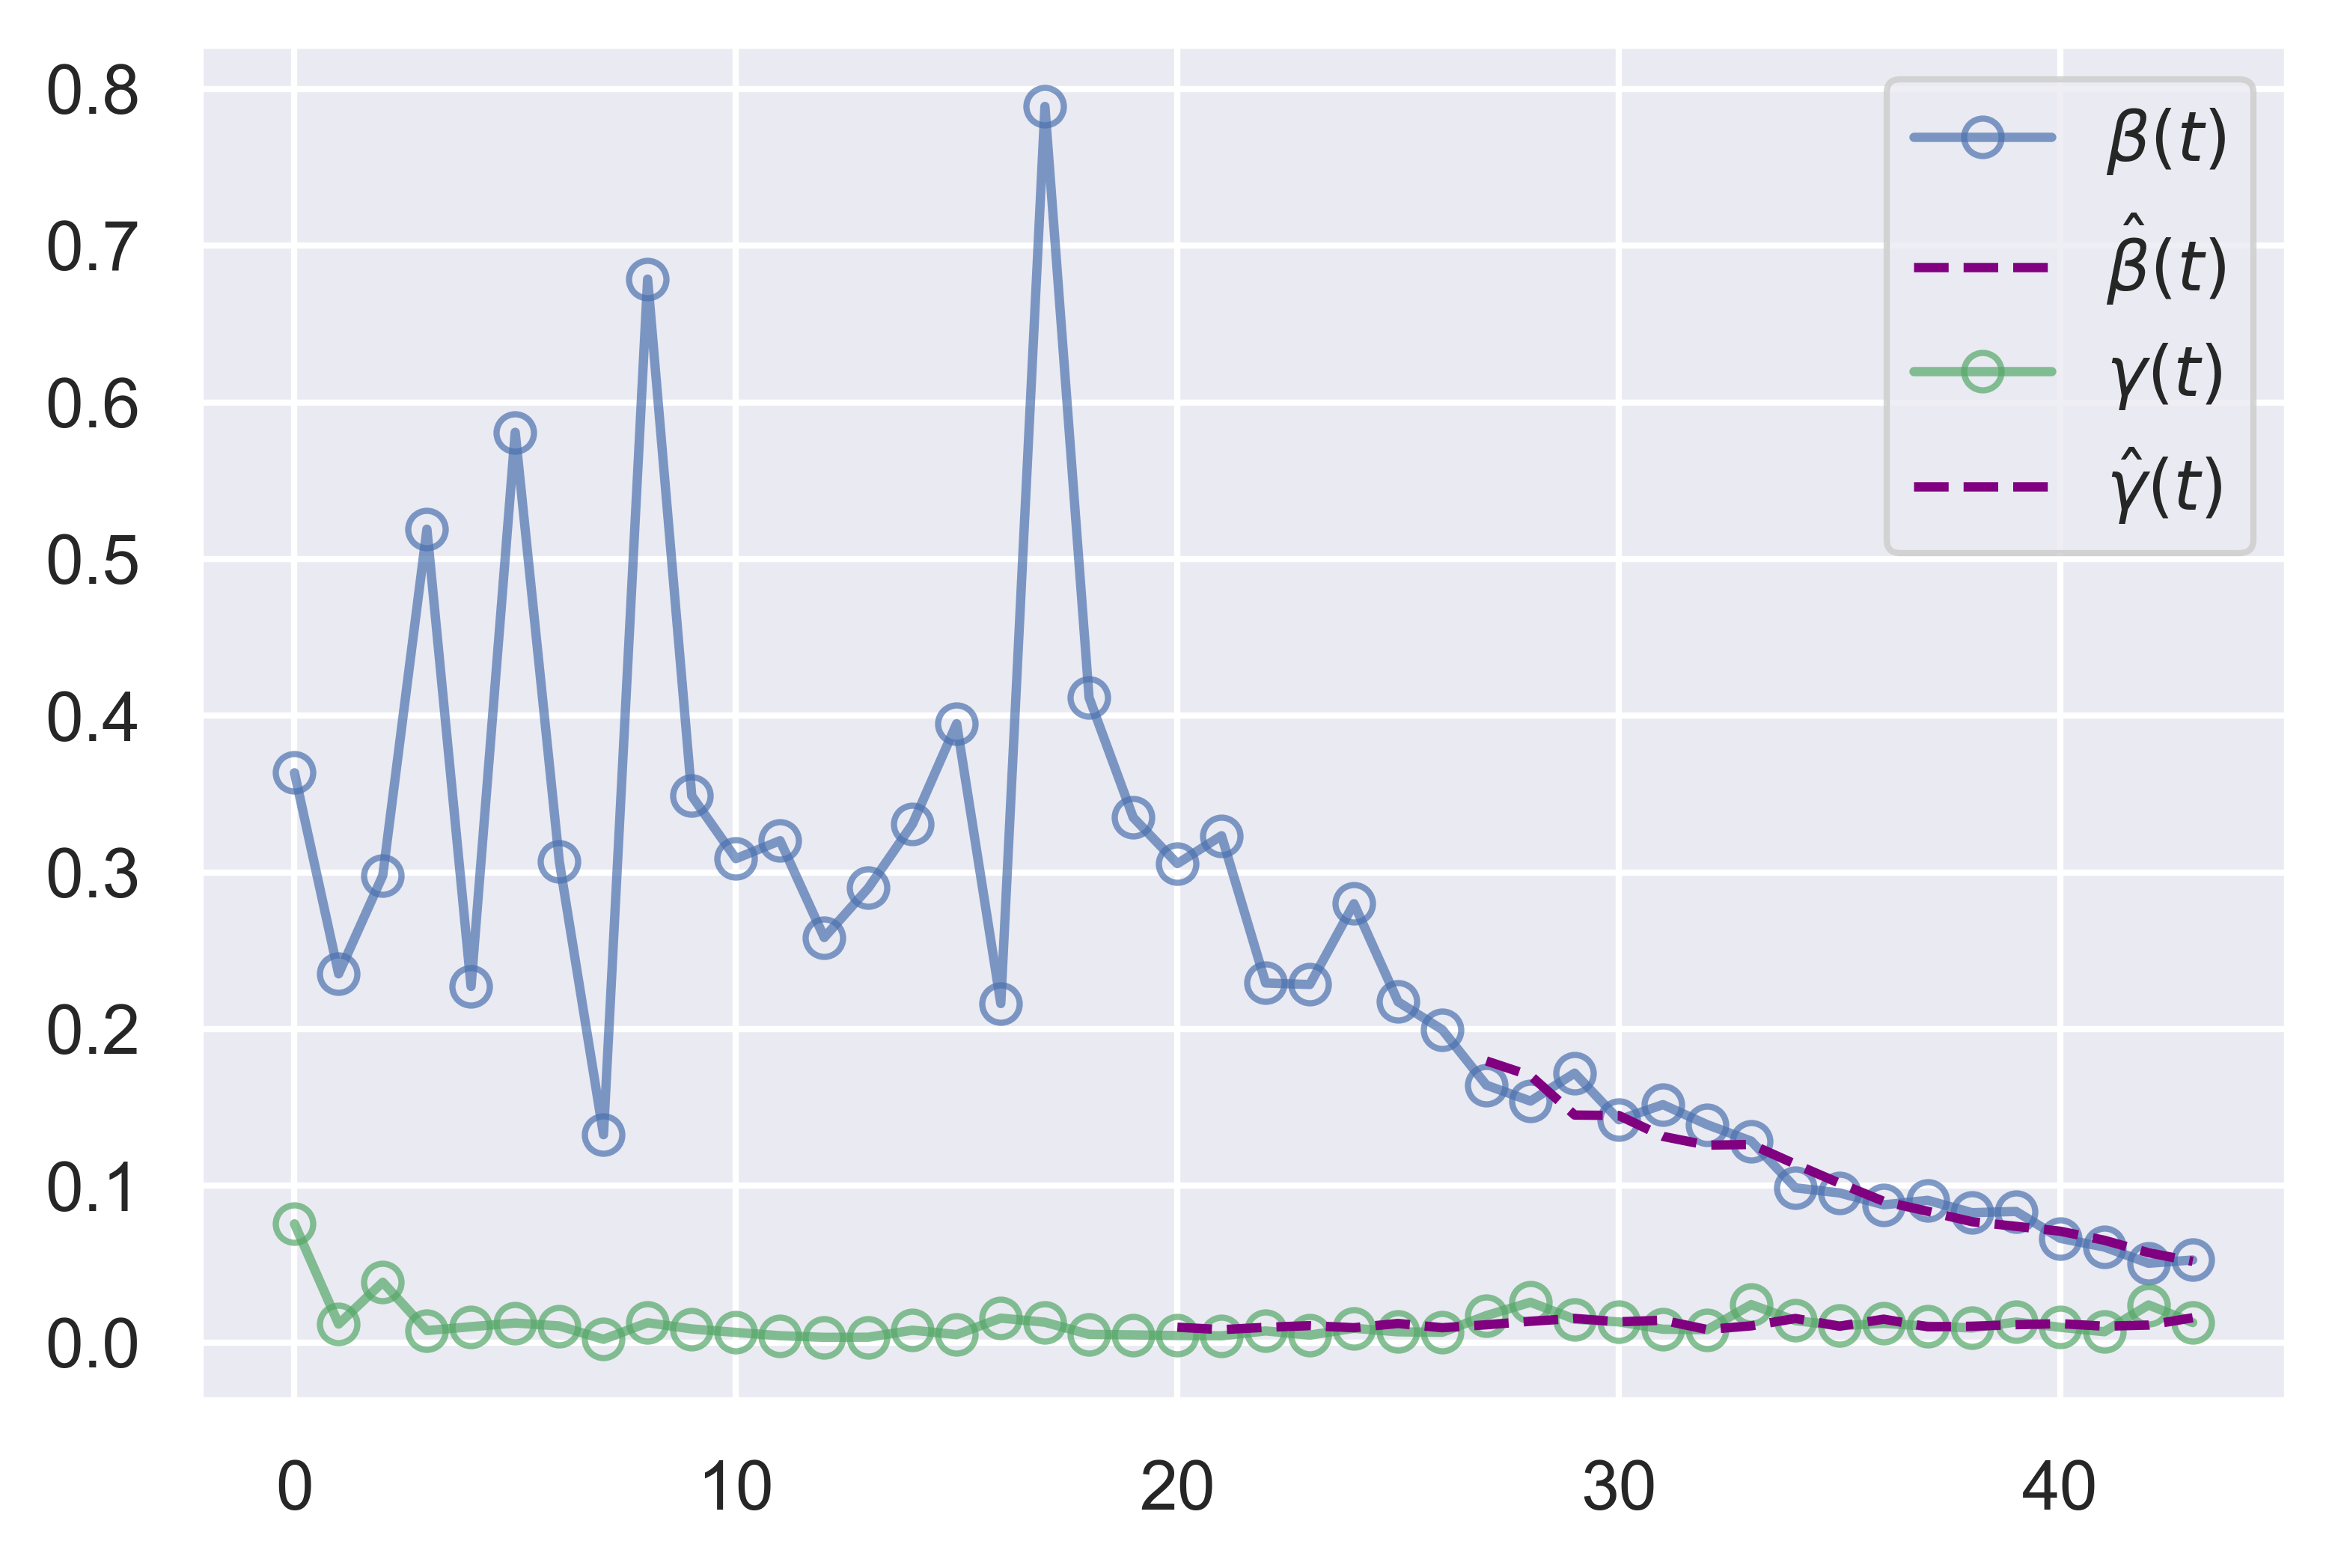

In [7]:
# Plot actual vs. predicted transmission and recovery rates

plt.figure(1)
plt.plot(beta, 'o-', markerfacecolor='none', label=r'$\beta (t)$', color='b', alpha=.7)
plt.plot(np.arange(len(beta)-len(beta_hat), len(beta)), beta_hat, '--', label=r'$\hat{\beta}(t)$', color='purple')
plt.legend()

plt.plot(gamma, 'o-', markerfacecolor='none', label=r'$\gamma (t)$', color='g', alpha=.7)
plt.plot(np.arange(len(gamma)-len(gamma_hat), len(gamma)), gamma_hat, '--', label=r'$\hat{\gamma}(t)$', color='purple')
plt.legend()

plt.show()

## Time Dependent Discrete SIR Model

In [8]:
##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria
stop_day = 120 # maximum iteration days (W in the paper)

day_count = 0
turning_point = 0

S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta= beta[-orders_beta:].tolist()
predict_gamma = gamma[-orders_gamma:].tolist()

while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
    if predict_beta[-1] > predict_gamma[-1]:
        turning_point += 1
    
    next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
    next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

    next_beta = max(next_beta,0)
#     next_gamma = max(next_gamma,0)
#     next_gamma = max(next_gamma, .01)
    next_gamma = max(next_gamma, 1./23)

    
    predict_beta.append(next_beta)
    predict_gamma.append(next_gamma)

    next_S = ((-predict_beta[-1] * S_predict[-1] *
               X_predict[-1]) / n[-1]) + S_predict[-1]
    next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
              n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
    next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

    S_predict.append(next_S)
    X_predict.append(next_X)
    R_predict.append(next_R)

    day_count += 1

In [9]:
# Shows progression of predicted reproduction rate (Should be <1 to converge to DFE)
r0_predict = pd.DataFrame({'beta':predict_beta, 'gamma':predict_gamma})
r0_predict['r0'] = r0_predict.beta / r0_predict.gamma
r0_predict['recoverydays'] = 1/r0_predict.gamma
r0_predict.head(3)

,beta,gamma,r0,recoverydays
0,0.066482,0.009700,6.853569,103.089052
1,0.060921,0.006900,8.829618,144.935267
2,0.050581,0.023991,2.108306,41.681663


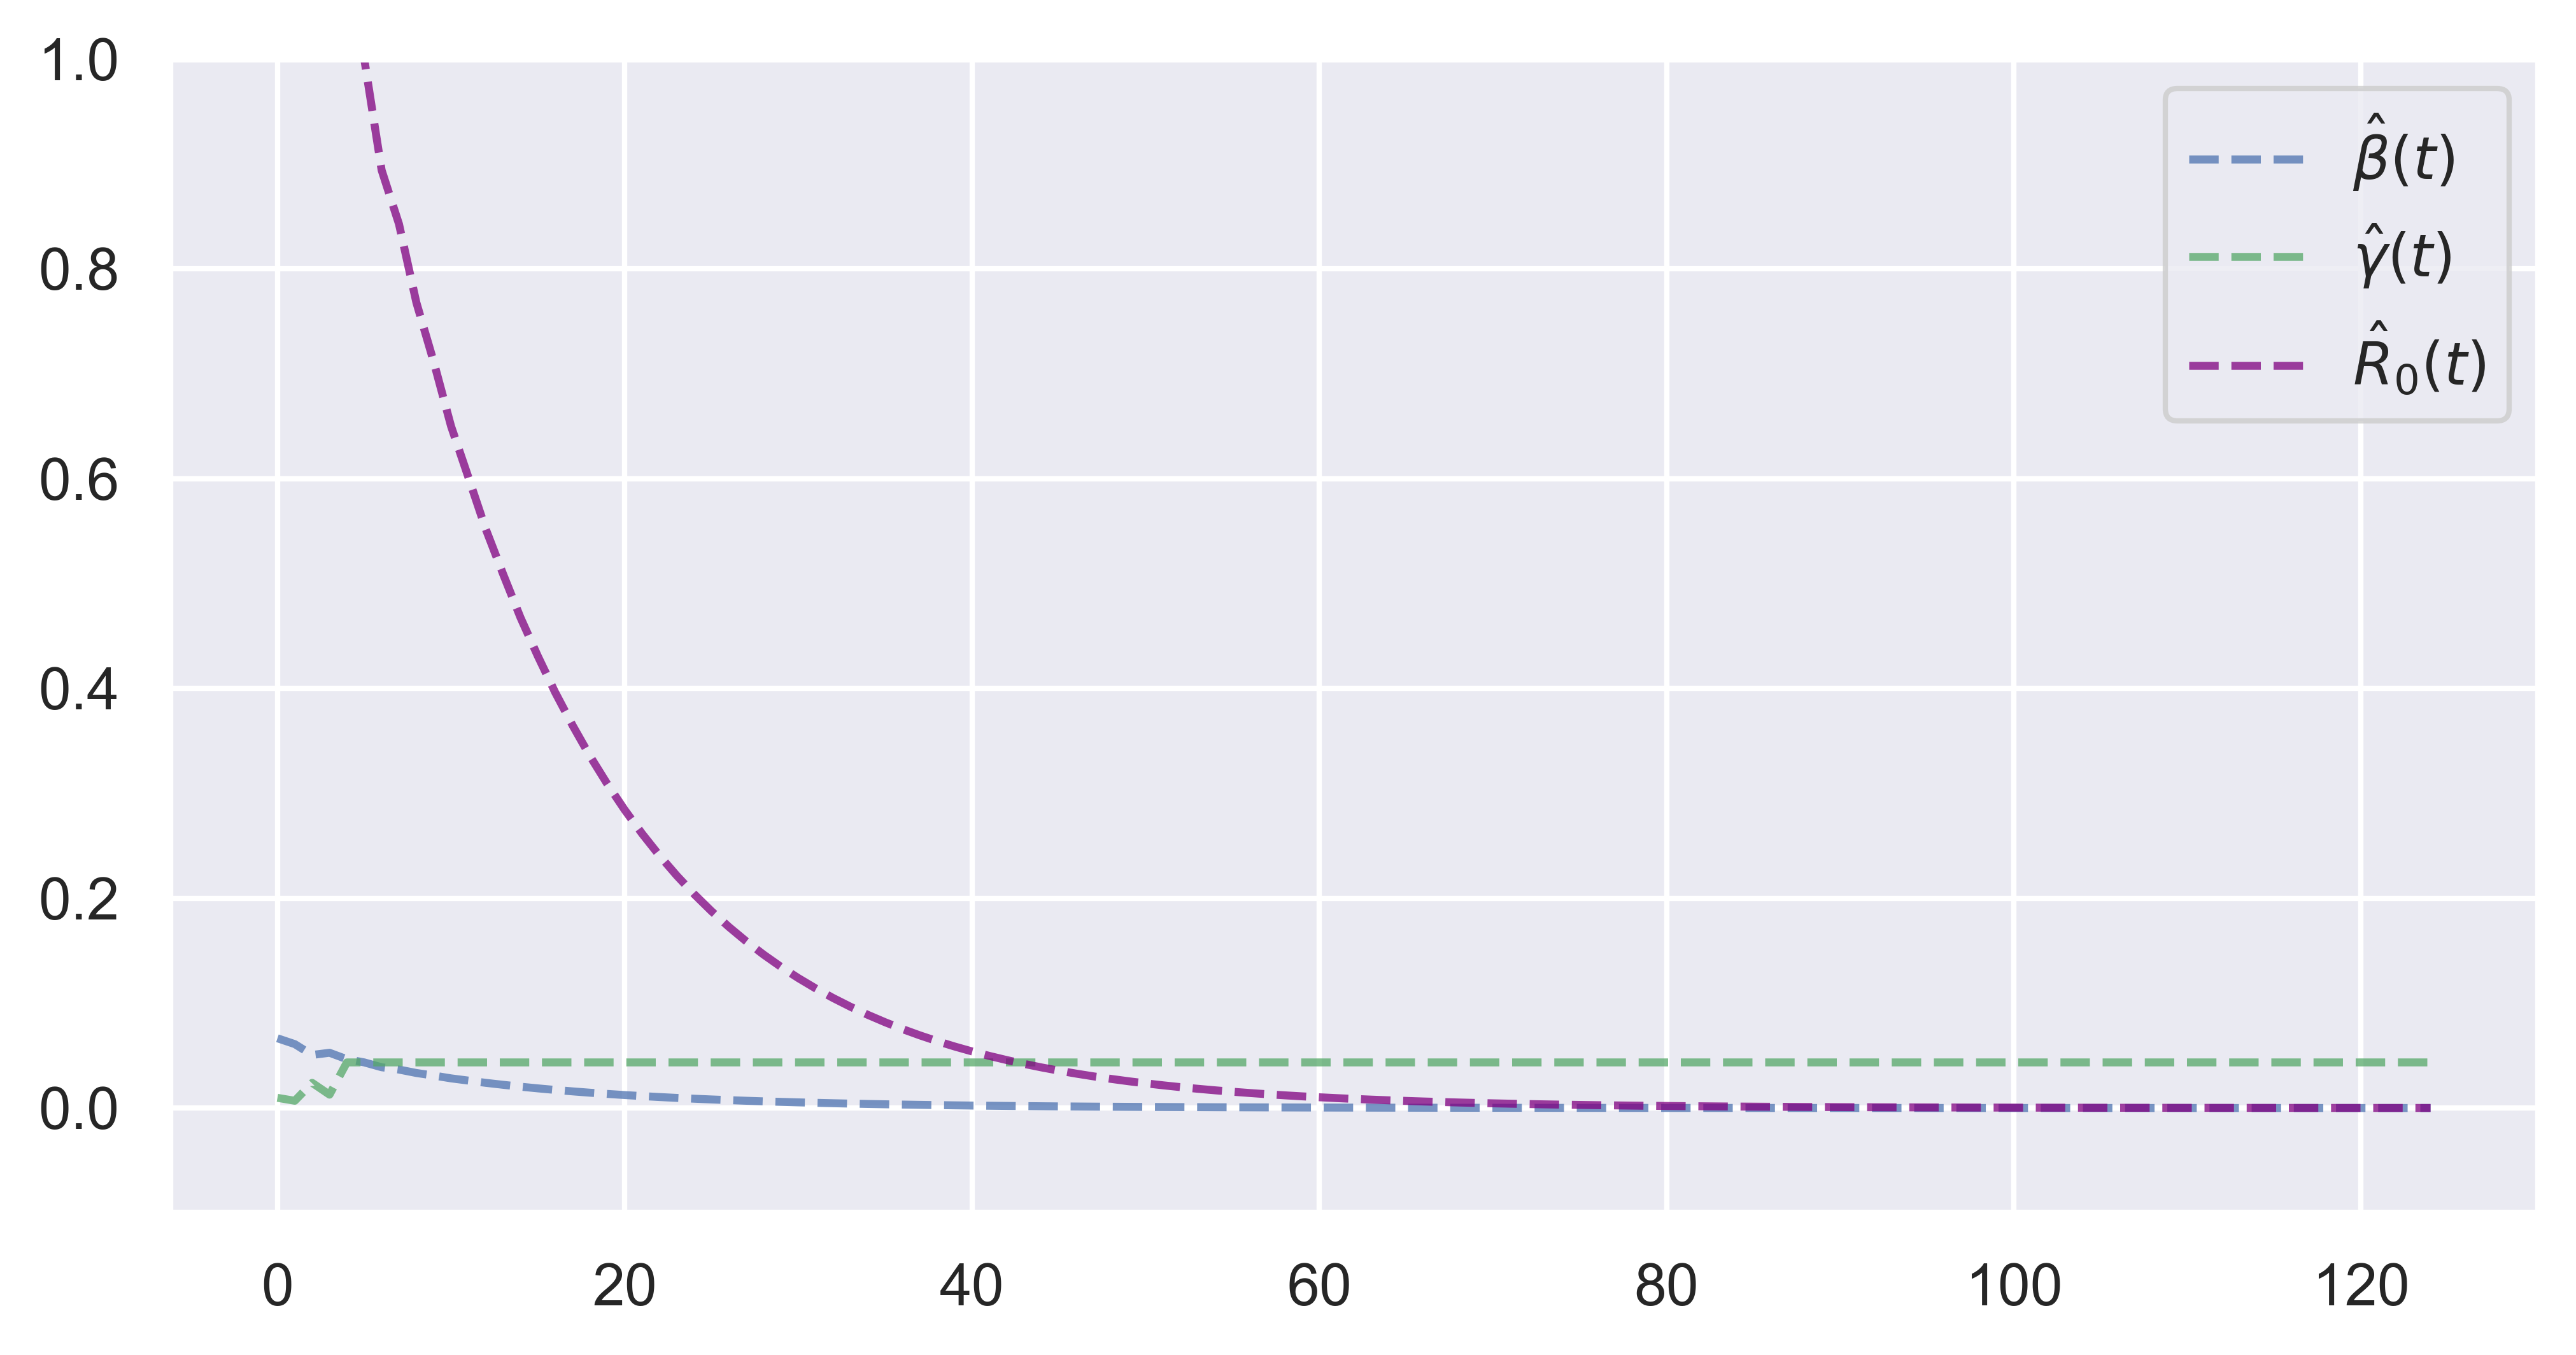

In [10]:
# Plot projected transmission and recovery rates

plt.figure(2, figsize=(8,4))

plt.plot(r0_predict.beta, '--', markerfacecolor='none', label=r'$\hat{\beta} (t)$', color='b', alpha=.75)
plt.plot(r0_predict.gamma, '--', markerfacecolor='none', label=r'$\hat{\gamma} (t)$', color='g',alpha=.75)
plt.plot(r0_predict.r0, '--', markerfacecolor='none', label=r'$\hat{R}_0 (t)$', color='purple',alpha=.75)

plt.ylim(top=1, bottom=-.1)
plt.legend()
plt.show()

In [11]:
# Print Highlight Predictions from Model 
print('Predictions:')
print('\nConfirmed cases tomorrow:', np.rint(X_predict[1] + R_predict[1]))
print('Infected persons tomorrow:', np.rint(X_predict[1]))
print('Recovered + Dead persons tomorrow:', np.rint(R_predict[1]))

print('\nEnd day:', day_count+len(X)-1)
print('Confirmed cases on the end day:', np.rint(X_predict[-2] + R_predict[-2]))

print('\nTurning point:', turning_point)

Predictions:

Confirmed cases tomorrow: 632473.0
Infected persons tomorrow: 535700.0
Recovered + Dead persons tomorrow: 96773.0

End day: 165
Confirmed cases on the end day: 870506.0

Turning point: 3


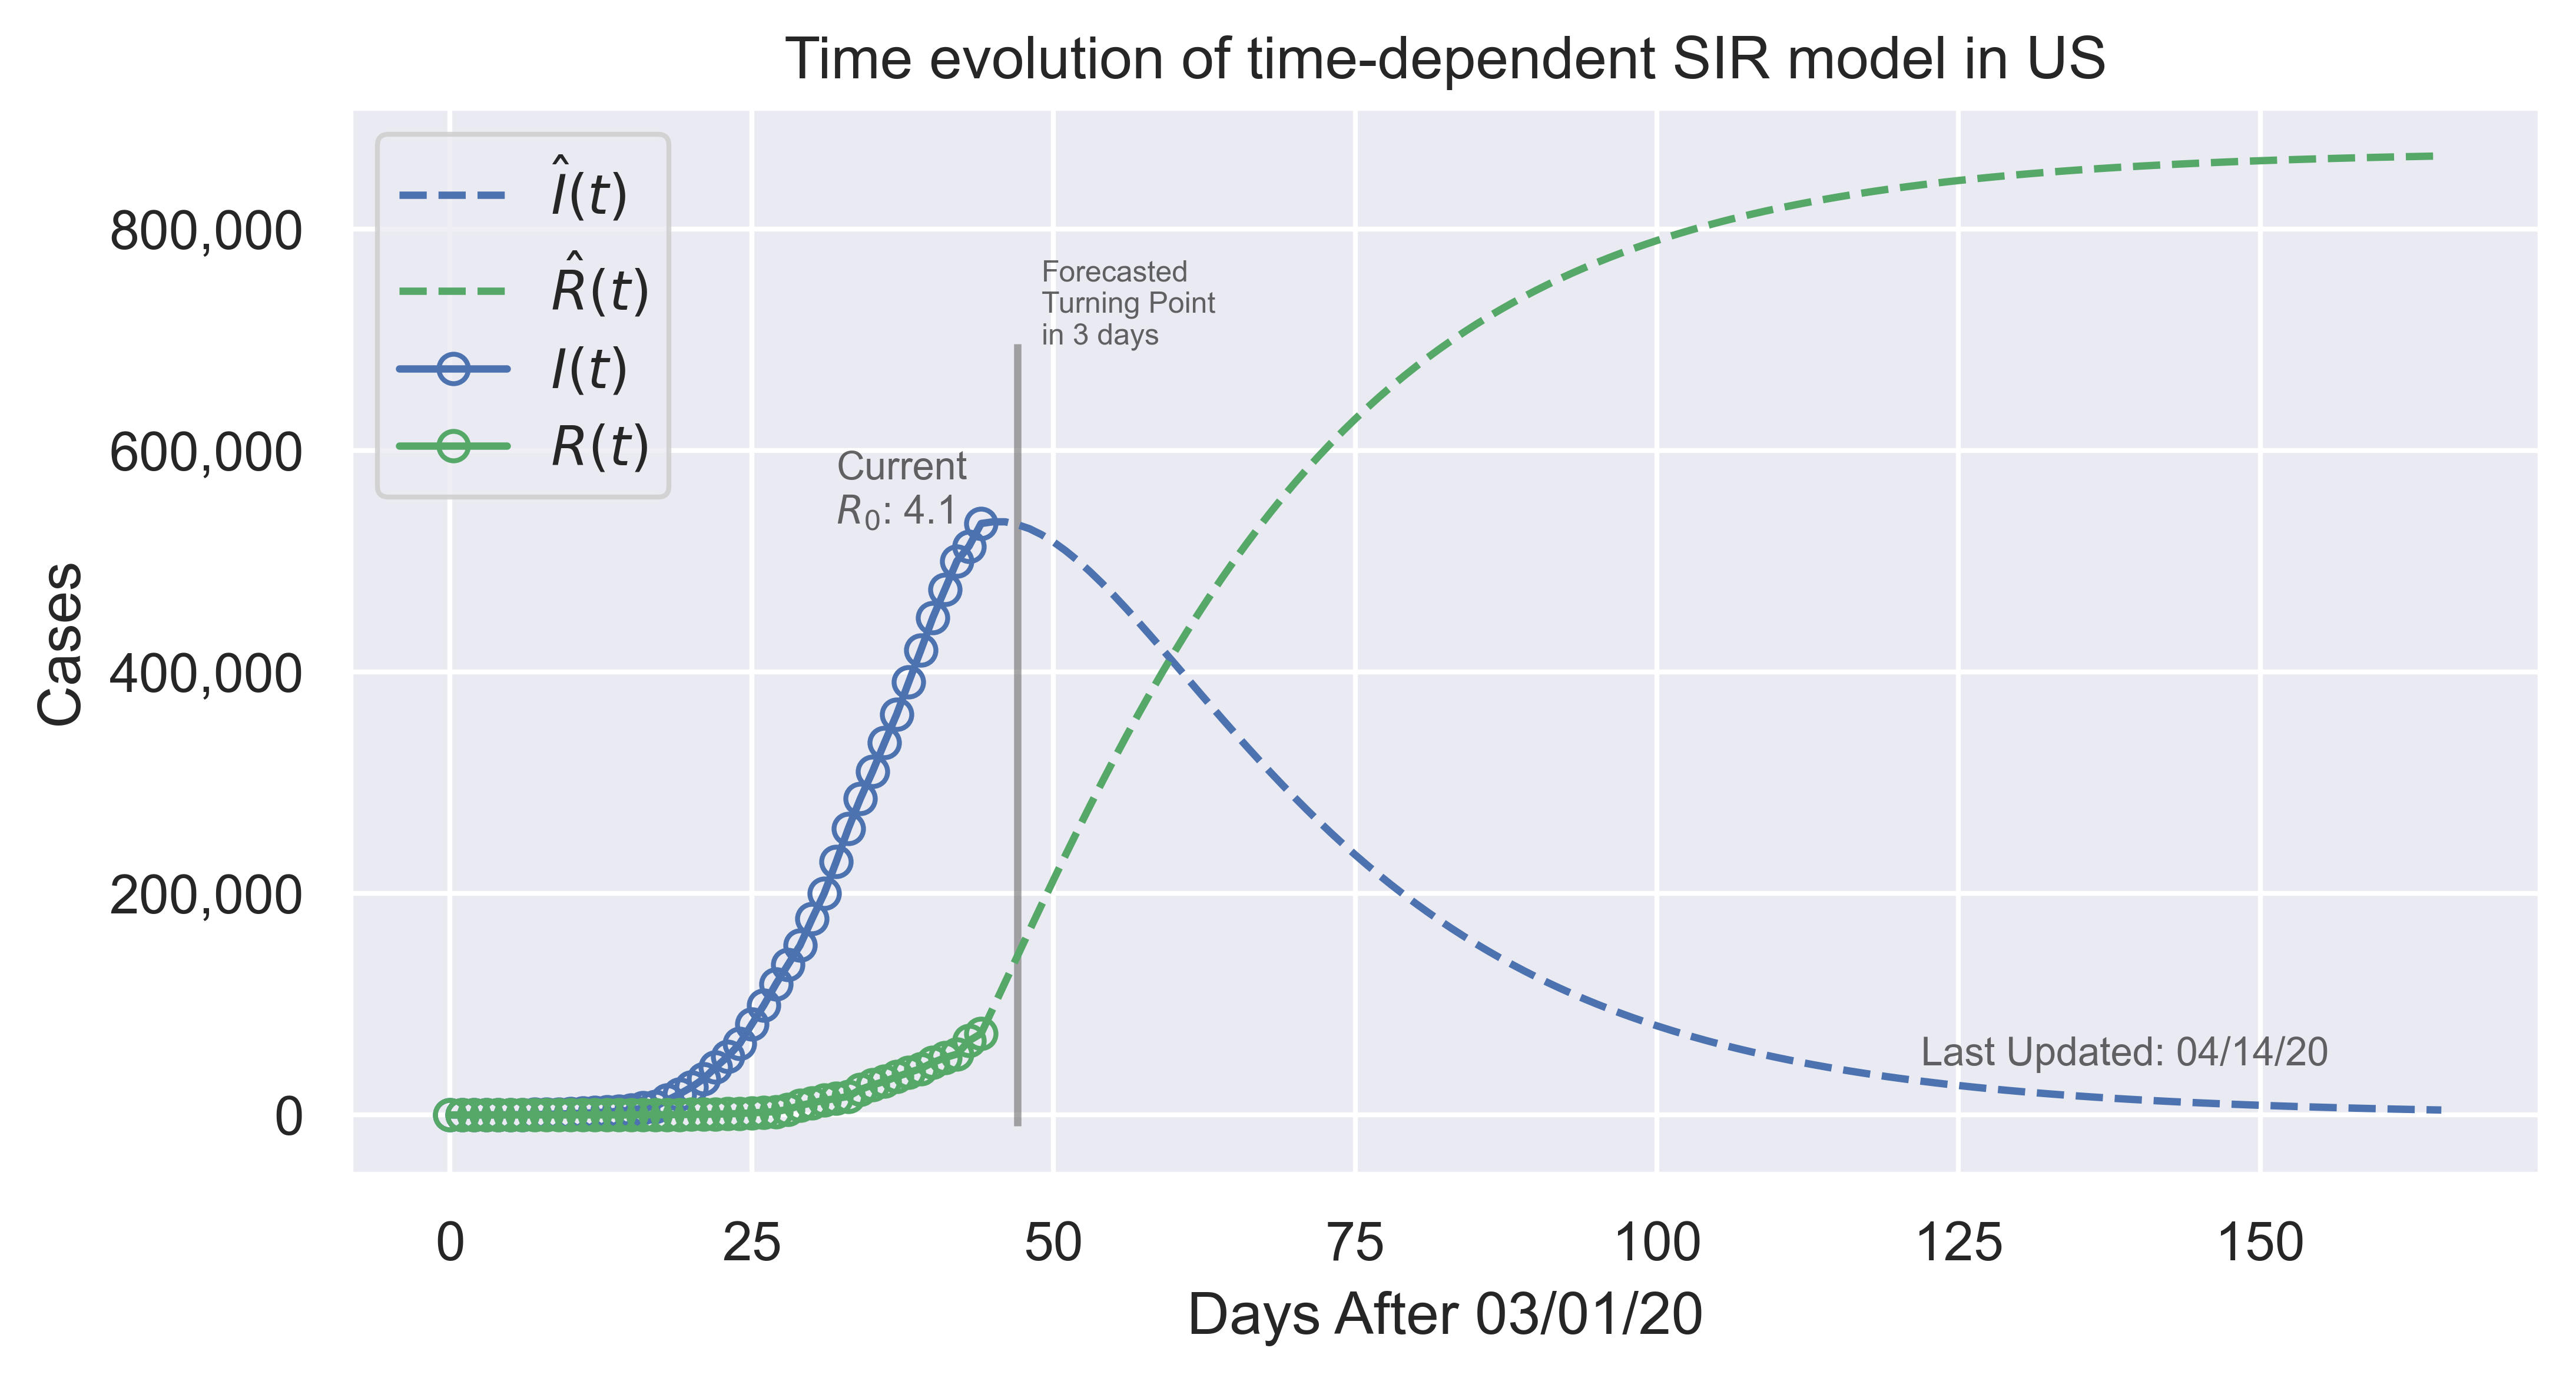

In [19]:
# Plot the time evolution of the time-dependent SIR model 
# plt.style.use('ggplot2')

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

# Plot S, I, R forecats
# ax.plot(range(len(S) - 1, len(S) - 1 + len(S_predict)), S_predict, '--', label=r'$\hat{S}(t)$', color='purple')
ax.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, '--', label=r'$\hat{I}(t)$', color='b')
ax.plot(range(len(R) - 1, len(R) - 1 + len(R_predict)), R_predict, '--', label=r'$\hat{R}(t)$', color='g')

# Plot S, I, R data
# ax.plot(range(len(S)), S, '-',  label=r'$S(t)$', markerfacecolor = 'none', color='purple')
ax.plot(range(len(X)), X, 'o-', label=r'$I(t)$', markerfacecolor = 'none', color='b')
ax.plot(range(len(R)), R, 'o-', label=r'$R(t)$', markerfacecolor = 'none', color='g')

# Plot forecasted turning point
if turning_point > 1:
    ax.vlines(len(X)-1+turning_point, ymin=-10000, ymax=max(X_predict)*1.3, linestyle='-', alpha=.7, color='grey')
    ax.text(x=len(X)-1+turning_point+2, y=max(X_predict)*1.3, s='Forecasted\nTurning Point\nin {} days'.format(turning_point), alpha=.7, fontsize=6)

# Plot most recent R0
if R0[-1] >= 0.1:
    ax.text(x=len(X)-13,y=X[-1], s='Current\n$R_0$: {}'.format(round(R0[-1],1)), fontsize=8, alpha=.7)

# Format y axis
# plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Formatting and such
ax.set_xlabel('Days After {}'.format(datetime(2020,3,1).strftime('%D')))
ax.set_ylabel('Cases')
ax.set_title('Time evolution of time-dependent SIR model in US')
ax.legend()

ax.text(x=day_count,y=X_predict[day_count]*10, s=' Last Updated: {}'.format(datetime.now().strftime('%D')), fontsize=8, alpha=.7)

fig.show(warn=False)

In [14]:
days = 3
preds = pd.DataFrame({'DaysElapsed':83+np.arange(days),
                      'InfectedPred': np.rint(X_predict[1:days+1]),
                      'RecoveredPred': np.rint(R_predict[1:days+1]),
                     }) 
preds['ConfirmedPred'] = preds.InfectedPred + preds.RecoveredPred
preds[['DaysElapsed','ConfirmedPred']]

,DaysElapsed,ConfirmedPred
0,83,632473.0
1,84,655724.0
2,85,676506.0
